<a href="https://colab.research.google.com/github/risa1796/Forecasting-Regression-exercises/blob/main/Forecasting_number_of_Covid_19_patients_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting number of Covid-19 patients using CNN-LSTM

Reference: https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/time-series/Ch5-CNN-LSTM.ipynb?authuser=2#scrollTo=t7IVkw-ErTn4

In [176]:
%cd /content/drive/MyDrive/딥러닝기초

/content/drive/MyDrive/딥러닝기초


## Dependencies

In [177]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data Upload

In [178]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1B36Djko-f0LtVxSaBEVYosLTTsu0qtsh
To: /content/drive/MyDrive/딥러닝기초/COVIDTimeSeries.zip
100% 3.18M/3.18M [00:00<00:00, 143MB/s]
COVIDTimeSeries.zip download complete!
replace covid_19_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace time_series_covid19_confirmed_global.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [179]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [180]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,47851,48053,48116,48229,48527,48718,48952,49161,49378,49621
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,45188,46061,46863,47742,48530,49191,50000,50637,51424,52004
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,90014,90579,91121,91638,92102,92597,93065,93507,93933,94371
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7162,7190,7236,7288,7338,7382,7382,7446,7466,7519
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15804,15925,16061,16161,16188,16277,16362,16407,16484,16562


In [181]:
df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

We will take Germany data points only.

In [182]:
de_df = df[df['Country/Region']=='Korea, South']
de_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
157,NaN,"Korea, South",35.907757,127.766922,1,1,2,2,3,4,...,40098,40786,41736,42766,43484,44364,45442,46453,47515,48570


We will get subdatframe containing only the columns with patient numbers.

## Data Preprocessing

In [183]:
de_dff = de_df.iloc[:,4:]
de_dff.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
157,1,1,2,2,3,4,4,4,4,11,...,40098,40786,41736,42766,43484,44364,45442,46453,47515,48570


The date range is 1/22/20 - 12/18/20

In [184]:
dd = de_dff.columns
print(len(dd),'days')

332 days


In [185]:
de_dffT = de_dff.T
de_dffT

,157
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,3
...,...
12/14/20,44364
12/15/20,45442
12/16/20,46453
12/17/20,47515


Change to date format

In [186]:
pd.to_datetime(de_dffT.index)

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18'],
              dtype='datetime64[ns]', length=332, freq=None)

In [187]:
de_dffT.index = pd.to_datetime(de_dffT.index)
de_dffT

,157
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,3
...,...
2020-12-14,44364
2020-12-15,45442
2020-12-16,46453
2020-12-17,47515


> .diff()

Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row).

In [188]:
daily_cases = de_dffT.diff().fillna(de_dffT.iloc[0]).astype('int')
daily_cases

,157
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1
...,...
2020-12-14,880
2020-12-15,1078
2020-12-16,1011
2020-12-17,1062


In [189]:
daily_cases[:10]

,157
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1
2020-01-27,1
2020-01-28,0
2020-01-29,0
2020-01-30,0
2020-01-31,7


## Plot daily cases

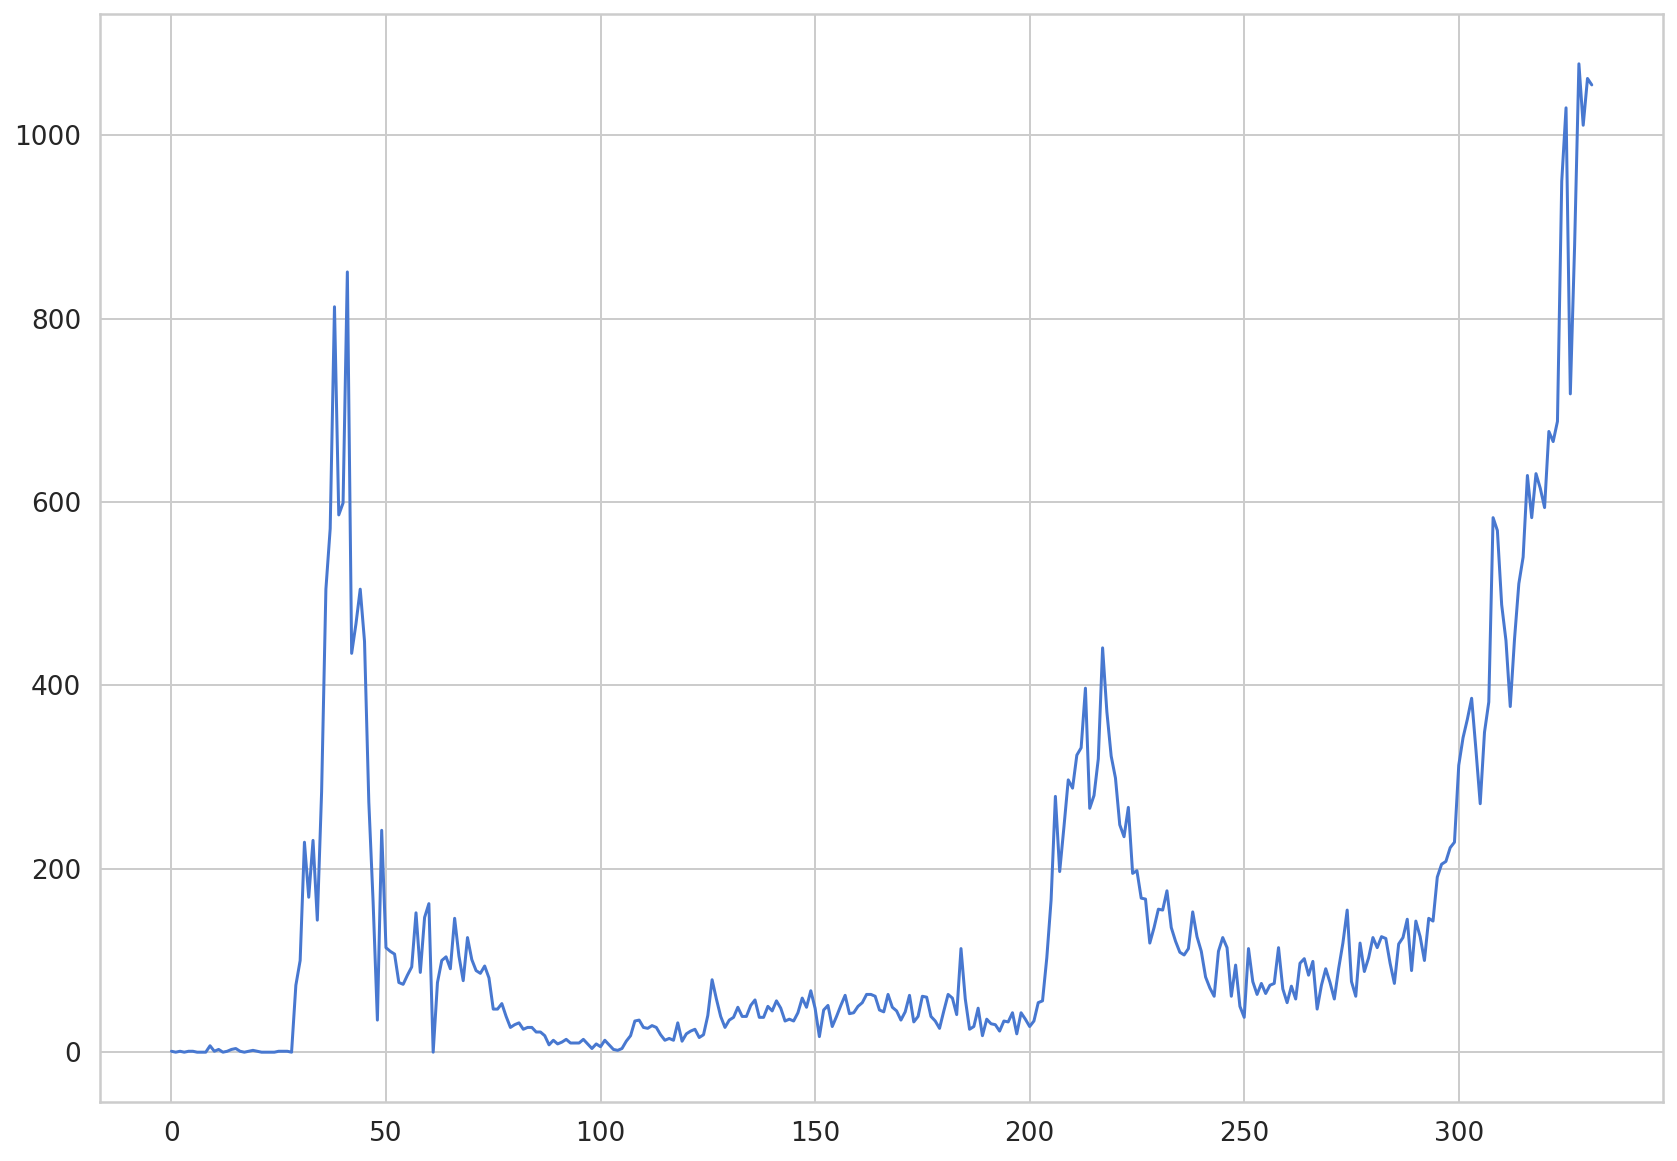

In [190]:
plt.plot(daily_cases.values)

## Create Sequences

In [191]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(daily_cases, seq_length)

In [192]:
X[:10]

array([[[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [7]],

       [[0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [7],
        [1]],

       [[1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [7],
        [1],
        [3]],

       [[0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [7],
        [1],
        [3],
        [0]],

       [[1],
        [1],
        [0],
        [0],
        [0],
        [7],
        [1],
        [3],
        [0],
        [1]],

       [[1],
        [0],
        [0],
        [0],
        [7],
        [1],
        [3],
        [0],
        [1],
        [3]],

       [[0],
        [0],
        [0],
        [7],
        [1],
        [3],
        [0],
        [1],
        [3],
        [4]],

       [[0],
        [0],
        [7],
        [1],
        [3],
        [0]

## Train, Validation, Test dataset split



In [193]:
train_size = int(len(dd) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

In [194]:
print(len(X_train))
len(X_val)

265


33

## MinMax Scaler

In [195]:
def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax Scaling
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

## Convert to Tensor

In [196]:
#convert to Tensor 
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [197]:
print(X_train.shape,y_train.shape)

torch.Size([265, 10, 1]) torch.Size([265, 1])


X_train :  261 samples, each sample is a serie with 5 elements, 1 dimension.

## CNN-LSTM

### What is 1D CNN ?

![그림 5-1](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img01.png?raw=true)



- Illustrating the movement of kernel in one dimensional CNN. 
- Kernel moves to right as time changes.
- When dealing with Time-Series data, 1D CNN is appropriate. Using 1D CNN you can extract regional features.


![그림 5-2](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img02.png?raw=true)
![그림 5-3](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/TS-ch5img03.png?raw=true)

Please check out how this works! Explanation in https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/time-series/Ch5-CNN-LSTM.ipynb?authuser=2#scrollTo=4Yj7Wnr15rDv

Chapter 5.2.2

CNN LSTM is simply saying, adding CNN layer to LSTM! 

### Define CNN-LSTM layers

In [198]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

### Define training process

In [199]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함 

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [200]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [201]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


## Train model

In [202]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=200,
    verbose=20,
    patience=50
)

Epoch 0 train loss: 0.1959469504443542 val loss: 0.12652987241744995
Epoch 20 train loss: 0.034897886341402555 val loss: 0.05043329298496246
Epoch 40 train loss: 0.033653355377532966 val loss: 0.04841044172644615
Epoch 60 train loss: 0.03308104116311473 val loss: 0.045799773186445236
Epoch 80 train loss: 0.03274433316645335 val loss: 0.04837749898433685
Epoch 100 train loss: 0.0327666797332536 val loss: 0.04865231737494469
Epoch 120 train loss: 0.03287098476013063 val loss: 0.04840102419257164
Epoch 140 train loss: 0.032571789756733575 val loss: 0.04645219072699547
Epoch 160 train loss: 0.032699464582223094 val loss: 0.04767758026719093
Epoch 180 train loss: 0.03249011634989589 val loss: 0.04799412563443184


## Plot training process 

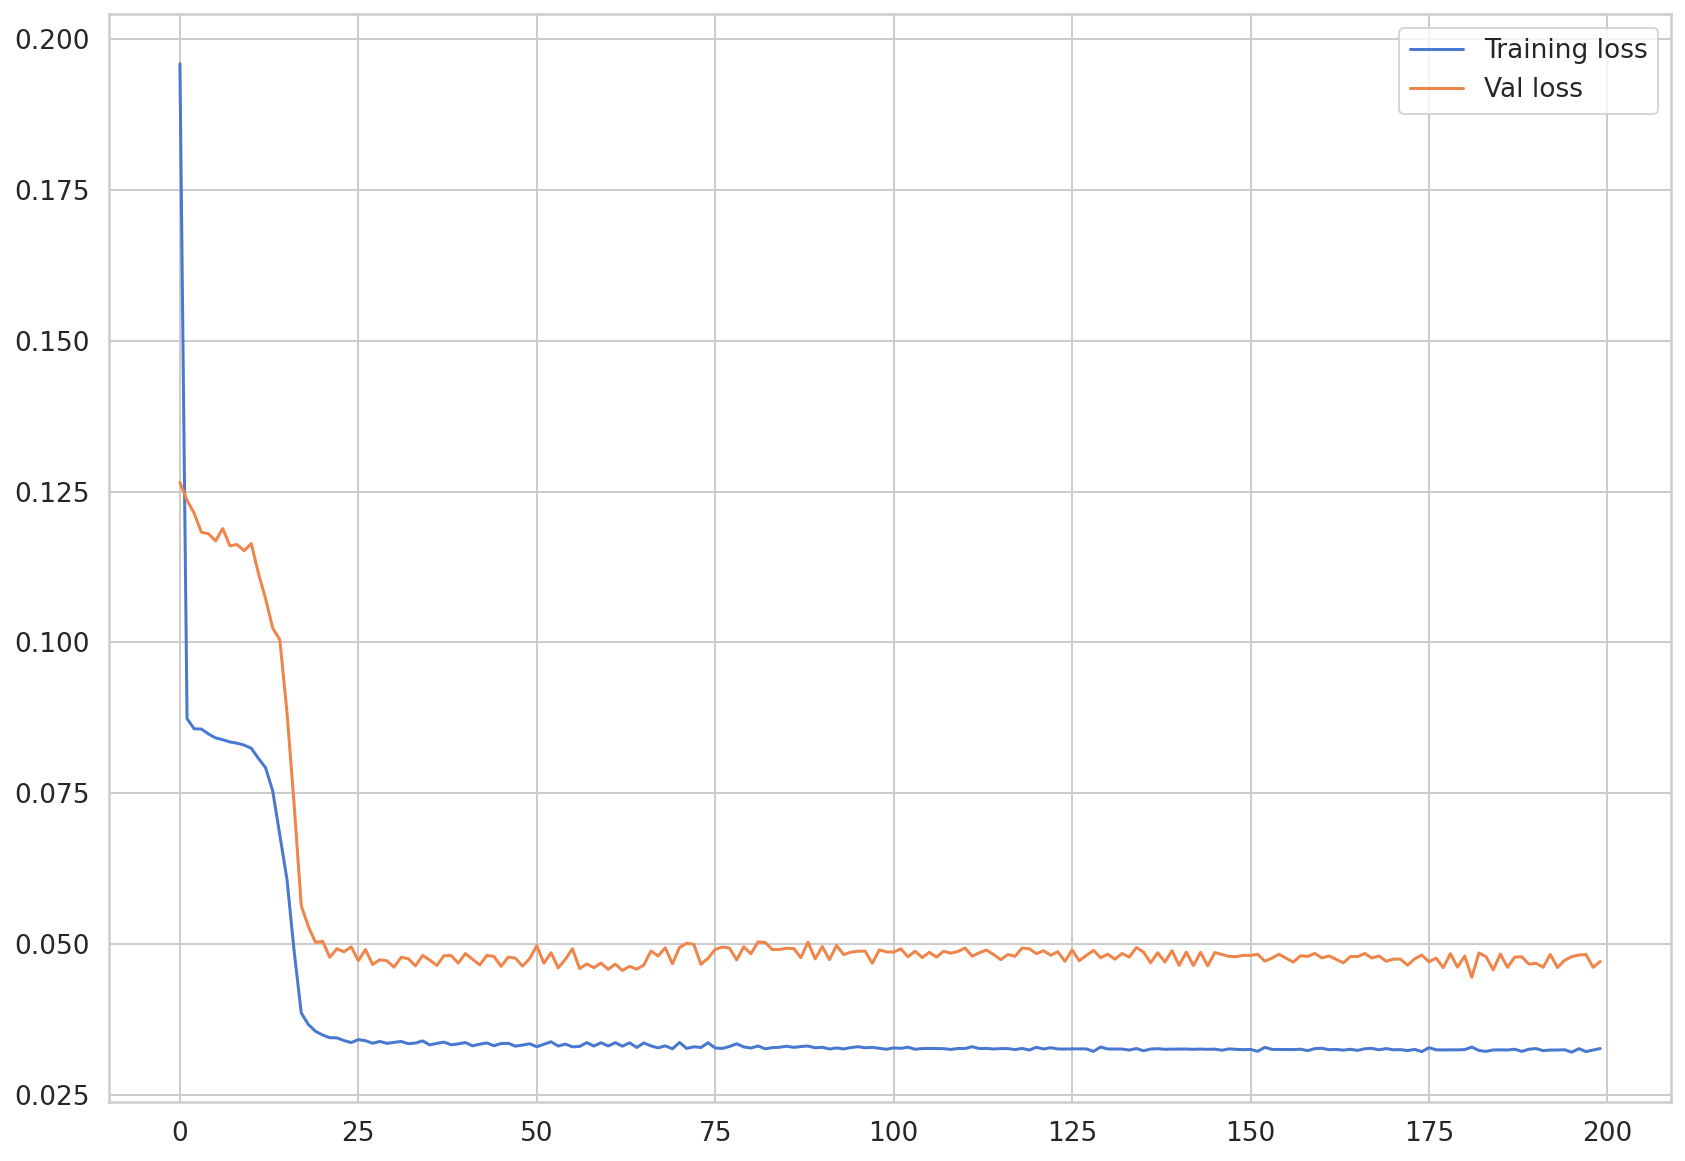

In [203]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

## Predict 

In [204]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

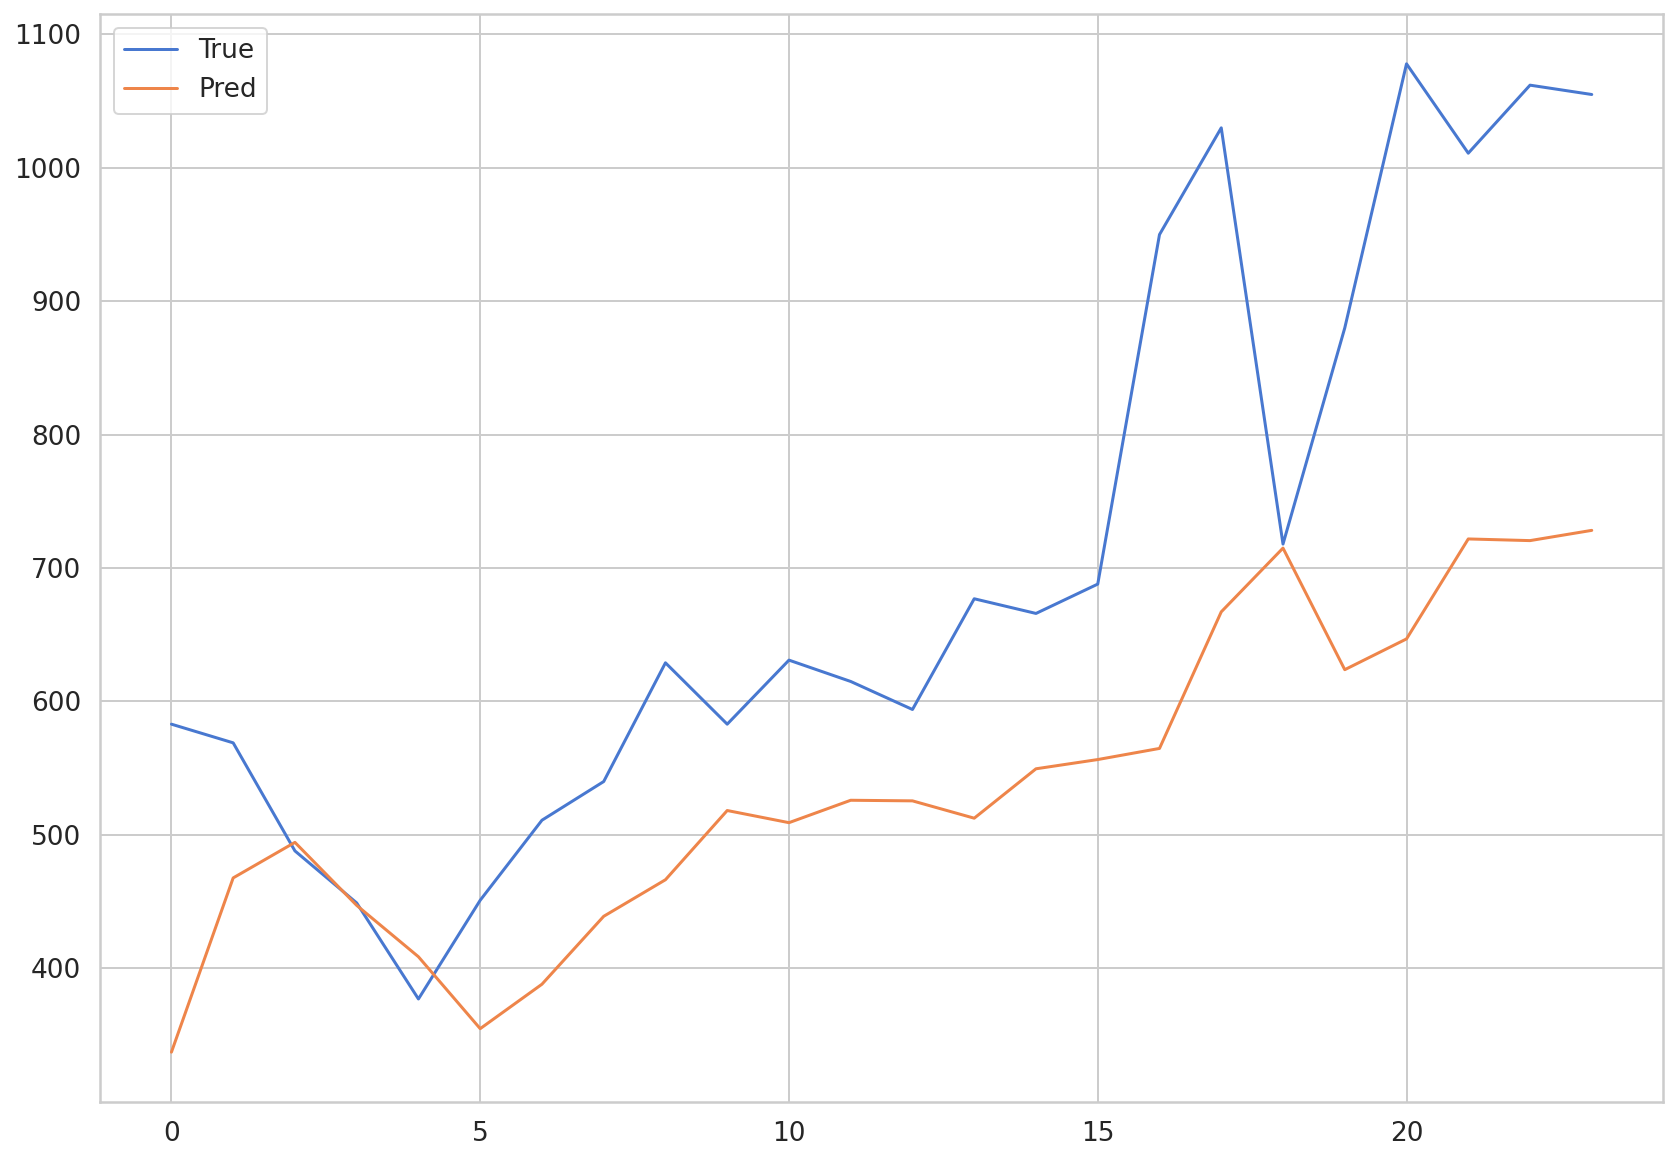

In [205]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [206]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [207]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

226.64192380694053